In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_excel('005_example.xlsx', parse_dates = ['date_id'], index_col = 'date_id')

In [3]:
data.head()

,good_id,ship_store_id,price,promo,sale,promo_price,holiday,owner_id
date_id,,,,,,,,
2018-09-16,149045,40,699,0,1,699,0,2
2018-03-17,149045,40,599,0,0,599,0,2
2018-03-23,149045,40,599,0,0,599,0,2
2017-07-25,149045,40,599,0,2,599,0,2
2018-10-04,173544,13,1399,0,0,1399,0,2


date_id - дата

good_id - код товара

ship_store_id - код магазина

price - цена

promo - флаг промо

sale - продажи

promo_price - промо цена

holiday - флаг праздничного дня

owner_id - код региона


Задача:
1. Провести исследование данных. Представить результаты исследования и программный код.
2. Рассчитать регулярный прогноз (без промо) на 45, 46, 47, 48 календарные недели. Вы можете по своему усмотрению:
	а.	Делать прогноз на уровне дня, потом при подсчете результатов агрегировать прогноз и факт продаж на уровень недели.
	б.	Агрегировать продажи на уровень недели и рассчитывать прогноз на уровне недели.	 
Результат должен быть в разрезе good_id/ship_store_id/date (на уровне недели)
3. Оценить точность 1-MAPE понедельно. Представить результаты и код.

Чтобы избежать деления на ноль при рассчете MAPE, используйте модифицированную формулу:
MAPE = SUM(ABS(Predict-Fact)/MAX(Predict,Fact))

Как оцениваем:
1. Консолидируем прогноз и факт для пересечения ship_store_id / good_id  до уровня недели.
2. Из полученного прогноза "выкалываем" пересечения ship_store_id / good_id / неделя если в какой-либо день недели у товара было промо.
3. По оставшимся пересечениям ship_store_id / good_id / неделя зассчитываем MAPE для каждой недели.

Желательная недельная целевая точность (1-MAPE):
0.45 - удовлетворительно
0.5 - хорошо
0.55 - прекрасно!

Добавление столбца с суммой продаж:

In [4]:
def total(x):
    if x['promo'] == 1:
        return x['promo_price'] * x['sale']
    else:
        return x['price'] * x['sale']

In [5]:
data['total_sum'] = data.apply(total, axis = 1)

In [6]:
data.tail()

,good_id,ship_store_id,price,promo,sale,promo_price,holiday,owner_id,total_sum
date_id,,,,,,,,,
2018-04-01,149079,77,399,0,6,0,0,9,2394
2018-03-29,149079,77,399,0,2,0,0,9,798
2018-10-01,149079,77,499,0,0,0,0,9,0
2019-05-27,149079,77,499,0,0,0,0,9,0
2019-11-29,149079,77,499,1,3,399,0,9,1197


## 1. Анализ данных

Пропусков нет:

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 529577 entries, 2018-09-16 to 2019-11-29
Data columns (total 9 columns):
good_id          529577 non-null int64
ship_store_id    529577 non-null int64
price            529577 non-null int64
promo            529577 non-null int64
sale             529577 non-null int64
promo_price      529577 non-null int64
holiday          529577 non-null int64
owner_id         529577 non-null int64
total_sum        529577 non-null int64
dtypes: int64(9)
memory usage: 40.4 MB


Количество уникальных товаров:

In [8]:
data['good_id'].nunique()

50

Уникальных магазинов:

In [9]:
data['ship_store_id'].nunique()

46

Статистические показатели цен:

In [10]:
data[['price', 'promo_price', 'total_sum']].describe()

,price,promo_price,total_sum
count,529577.000000,529577.000000,529577.000000
mean,1810.793116,1645.802635,1130.190807
std,1661.186857,1696.733974,5316.263835
min,119.000000,0.000000,0.000000
25%,799.000000,599.000000,0.000000
50%,1299.000000,999.000000,0.000000
75%,2599.000000,2599.000000,399.000000
max,10999.000000,10999.000000,406926.000000


Исключаем промо:

In [11]:
data = data[data['promo'] == 0]

Понедельная динамика продаж. Общий тренд растущий:

In [12]:
week_data = data.total_sum.resample('W').sum()

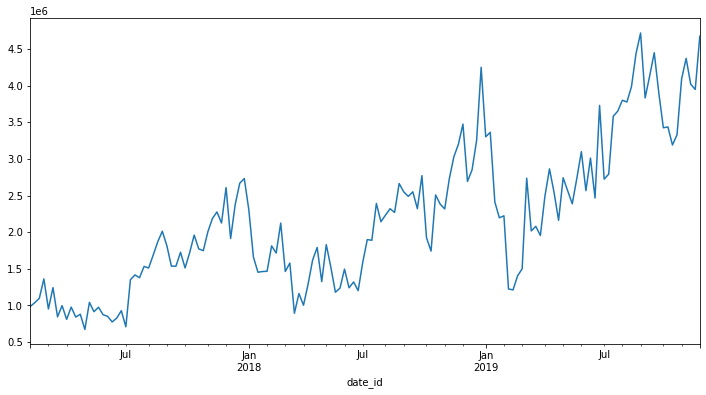

In [13]:
week_data.plot(figsize=(12,6))

Количество недель в датасете:

In [14]:
len(week_data)

148

### 2. Прогноз продаж

Для решения задачи используем Facebook Prophet:

In [15]:
from fbprophet import Prophet

In [16]:
df = week_data.reset_index()
df.columns = ['ds', 'y']

In [17]:
df.tail()

,ds,y
143,2019-11-03,4089218
144,2019-11-10,4373035
145,2019-11-17,4020875
146,2019-11-24,3948594
147,2019-12-01,4675259


Предсказывать будем последние 4 недели датасета:

In [18]:
predictions = 4

In [19]:
df_train = df[: - predictions]

In [20]:
df_train.tail()

,ds,y
139,2019-10-06,3425698
140,2019-10-13,3436958
141,2019-10-20,3190323
142,2019-10-27,3330439
143,2019-11-03,4089218


In [21]:
model = Prophet(yearly_seasonality = True, weekly_seasonality = True)

In [22]:
model.fit(df_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [23]:
future = model.make_future_dataframe(periods = predictions, freq = 'W')

In [24]:
forecast = model.predict(future)

Тренд растущий, присутствует ярко выраженная сезонность по месяцам:

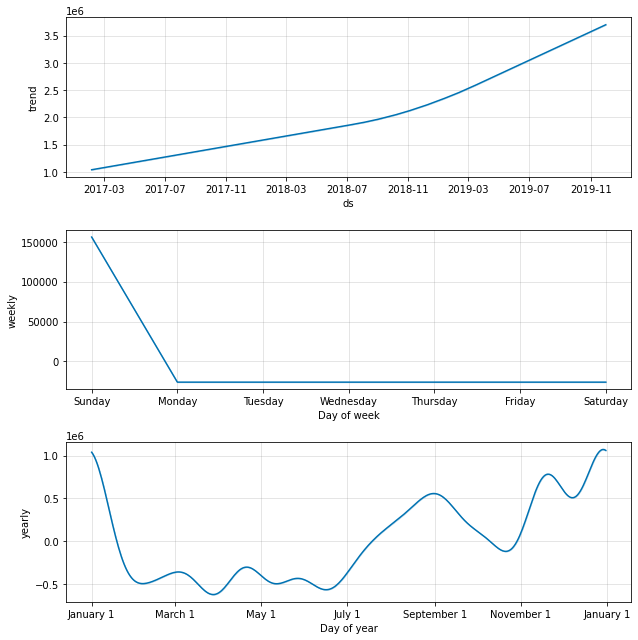

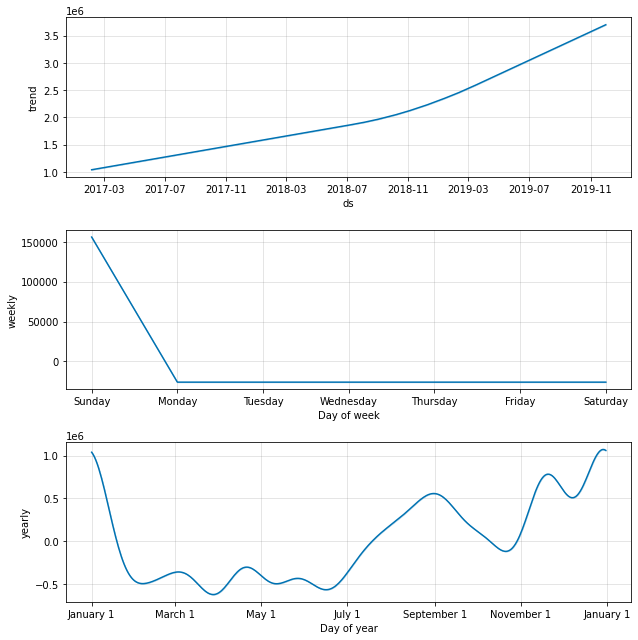

In [25]:
model.plot_components(forecast)

### 3. Проверка качества модели:

In [26]:
df_joined = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

In [27]:
df_joined[- predictions:]

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2019-11-10,4.272676e+06,3.872883e+06,4.665259e+06,4373035
2019-11-17,4.545393e+06,4.170252e+06,4.925036e+06,4020875
2019-11-24,4.585618e+06,4.182991e+06,4.989173e+06,3948594
2019-12-01,4.461205e+06,4.063679e+06,4.852809e+06,4675259


Расчет средней абсолютной ошибки (не использую модифицированную формулу т.к. деления на 0 не будет): 

In [28]:
df_joined['e'] = df_joined['y'] - df_joined['yhat']
df_joined['p'] = 100 * df_joined['e'] / df_joined['y']
print ('MAPE', np.mean(abs(df_joined[-predictions:]['p'])))
print ('MAE', np.mean(abs(df_joined[-predictions:]['e'])))

MAPE 9.012802140966262
MAE 368988.86550916056


Визуализация факта и прогноза:

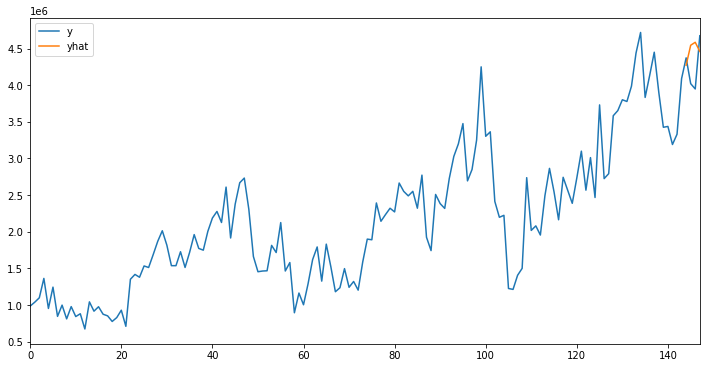

In [32]:
df_joined = df_joined.reset_index()
df_joined['ds'] = df_joined.ds.astype('str')
df_joined['yhat'][: - predictions] = np.nan
df_joined[['ds', 'y', 'yhat']].plot(figsize=(12,6))